# Loan Fraud application detection

In [1]:
# importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import stats
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sma
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, f1_score
from pylab import rcParams

In [2]:
rcParams['figure.figsize'] = 25,18

#### DATA DESCRIPTION: 
This data set contains 1668 loan_disbursed records and 3377 loan_rejected records. The data set was collected from New York, USA. action_taken is a class label used to divide into two groups (loan_disbursed (1) or loan_rejected(0)).


 agency_name: loan agency  


### 	Data Understanding

In [3]:
df = pd.read_csv('data_set.csv')
df.head()

,action_taken,agency_name,applicant_race,applicant_sex,lien_status_name,loan_purpose_name,applicant_annual_income,locality_median_family_income,loan_amount
0,1,HUD,White,Male,Secured by a first lien,Home purchase,121000.0,109000,232000
1,1,NCUA,White,Female,Secured by a first lien,Home improvement,31000.0,82700,9000
2,1,CFPB,American Indian or Alaska Native,Male,Secured by a first lien,Home purchase,82000.0,69000,210000
3,1,HUD,Asian,Male,Secured by a first lien,Refinancing,NaN,82700,178000
4,1,NCUA,White,Female,Secured by a first lien,Refinancing,83000.0,109000,200000


 applicant_race: race of the applicant

 applicant_sex: gender of applicant 

 lien_status_name: A lien gives a creditor the legal right to seize and sell a borrower's collateral property or asset which fails to fulfil a loan or contract obligations. The owner cannot sell the property that is the subject of a lien without the permission of the lien holder

 loan_purpose_name: Purpose for which loan is required

 applicant_annual_income: Annual income of applicant is US Dollars

 locality_median_family_income: Median income of family in the locality where property is located

 loan_amount: amount for which loan is needed

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2005 entries, 0 to 2004
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   action_taken                   2005 non-null   int64  
 1   agency_name                    2005 non-null   object 
 2   applicant_race                 2005 non-null   object 
 3   applicant_sex                  2005 non-null   object 
 4   lien_status_name               2005 non-null   object 
 5   loan_purpose_name              2005 non-null   object 
 6   applicant_annual_income        1844 non-null   float64
 7   locality_median_family_income  2005 non-null   int64  
 8   loan_amount                    2005 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 141.1+ KB


- It can be observed that the data consists of 9 columns and 2005 entries.
- There are five object columns and four numerical columns
- applicant_annula_income variable seems to have null values present.

In [19]:
df.shape

(1799, 9)

In [5]:
df.describe()

,action_taken,applicant_annual_income,locality_median_family_income,loan_amount
count,2005.00000,1.844000e+03,2005.000000,2.005000e+03
mean,0.83192,1.318509e+05,82902.992519,3.188274e+05
std,0.37403,1.508244e+05,17263.205510,8.580253e+05
min,0.00000,9.000000e+03,57200.000000,2.000000e+03
25%,1.00000,6.700000e+04,71300.000000,1.000000e+05
50%,1.00000,9.800000e+04,71300.000000,2.250000e+05
75%,1.00000,1.470000e+05,109000.000000,3.700000e+05
max,1.00000,2.414000e+06,109000.000000,3.185000e+07


- the standard deviation for locality_median_family_income seems to be higher showing a higher significance.
- the standard deviation for applicant_annual_income and loan_amount is significantly lower

In [7]:
# here action taken is the target variable as it displays the class of loan disbursed and rejected

df['action_taken'].value_counts()

1    1668
0     337
Name: action_taken, dtype: int64

In [8]:
# 1. checking for missing values

df.isnull().sum()

action_taken                       0
agency_name                        0
applicant_race                     0
applicant_sex                      0
lien_status_name                   0
loan_purpose_name                  0
applicant_annual_income          161
locality_median_family_income      0
loan_amount                        0
dtype: int64

The variable applicant_annual_income has 161 null values present

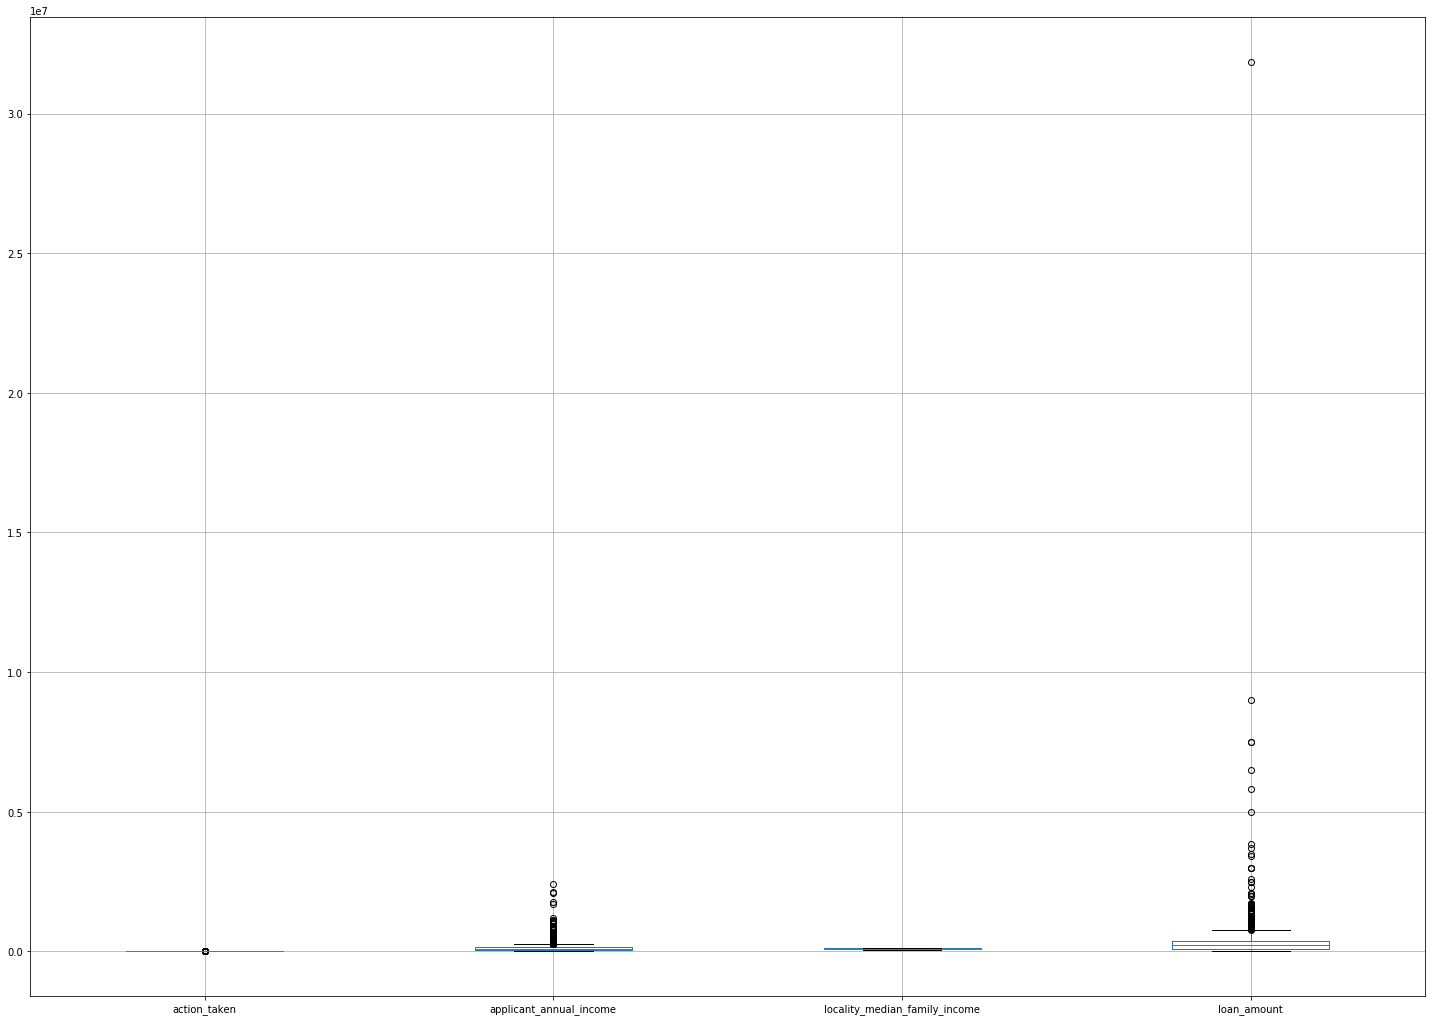

In [9]:
# checking outliers
df.boxplot()

Outliers are highly present in the columns applicant_annual_income and loan_amount

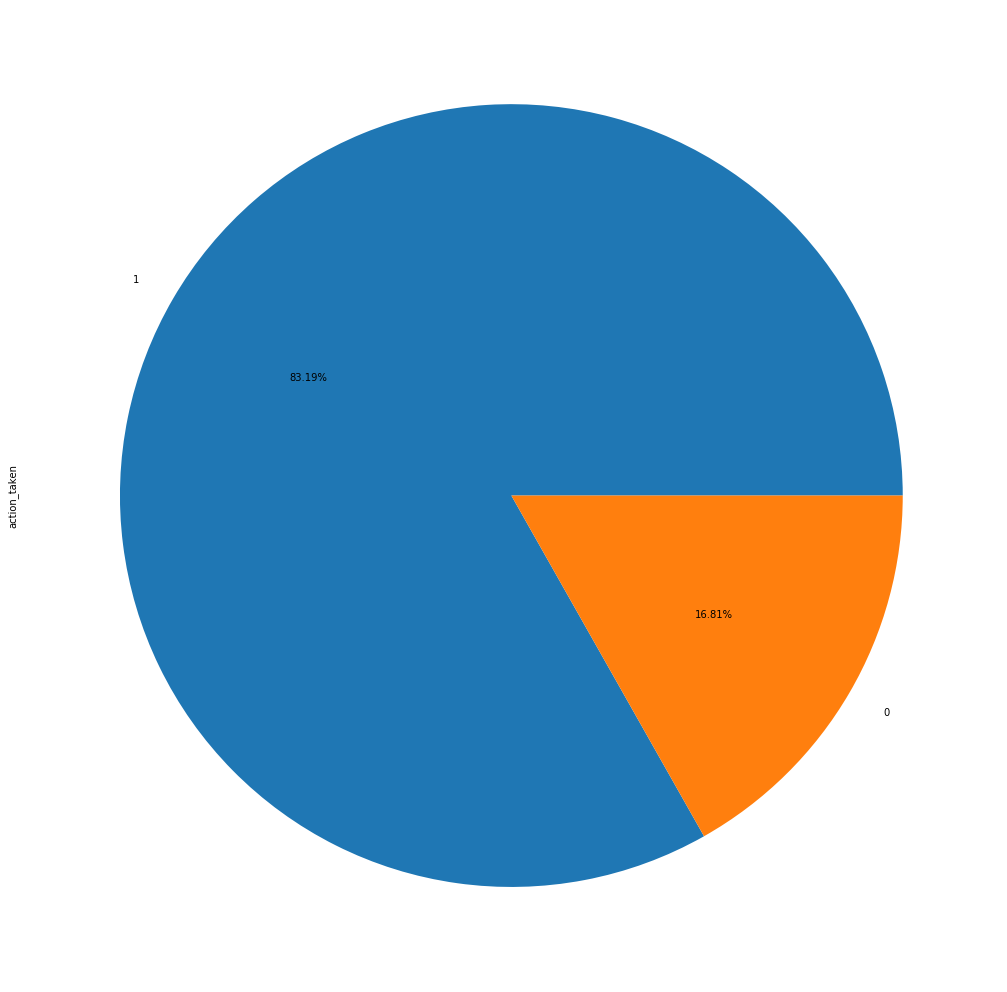

In [10]:
# for imbalance

df['action_taken'].value_counts().plot(kind = 'pie',autopct='%1.2f%%')

It is visible that class 0 has 16.81% of weightage in the data displaying a high imbalance of class distribution in the target variable

### Data Preparation 

In [11]:
#for a
# for null values
# since there are outliers present in the data we'll replace the null values with the median value.

df['applicant_annual_income'] = df['applicant_annual_income'].replace(np.nan,df['applicant_annual_income'].median())

In [12]:
df['applicant_annual_income'].isnull().sum()

0

In [13]:
# for outliers
# selecting the columns that have outliers present in them

df_out = df[['applicant_annual_income','loan_amount']]
df_out.head()

,applicant_annual_income,loan_amount
0,121000.0,232000
1,31000.0,9000
2,82000.0,210000
3,98000.0,178000
4,83000.0,200000


In [14]:
# performing outlier treatment on the same
# since the outliers are present only above the upper whisker we'll consider only the upperlimit for outlier treatment

q3 = df_out.quantile(0.75)
q1 = df_out.quantile(0.25)

iqr = q3-q1

ul = q3 + 1.5*iqr

df_outliers = df_out[~(df_out > ul).any(axis=1)].index

In [15]:
# reassigning the values after outlier treatment in the dataframe

df = df.iloc[df_outliers]
df.head()

,action_taken,agency_name,applicant_race,applicant_sex,lien_status_name,loan_purpose_name,applicant_annual_income,locality_median_family_income,loan_amount
0,1,HUD,White,Male,Secured by a first lien,Home purchase,121000.0,109000,232000
1,1,NCUA,White,Female,Secured by a first lien,Home improvement,31000.0,82700,9000
2,1,CFPB,American Indian or Alaska Native,Male,Secured by a first lien,Home purchase,82000.0,69000,210000
3,1,HUD,Asian,Male,Secured by a first lien,Refinancing,98000.0,82700,178000
4,1,NCUA,White,Female,Secured by a first lien,Refinancing,83000.0,109000,200000


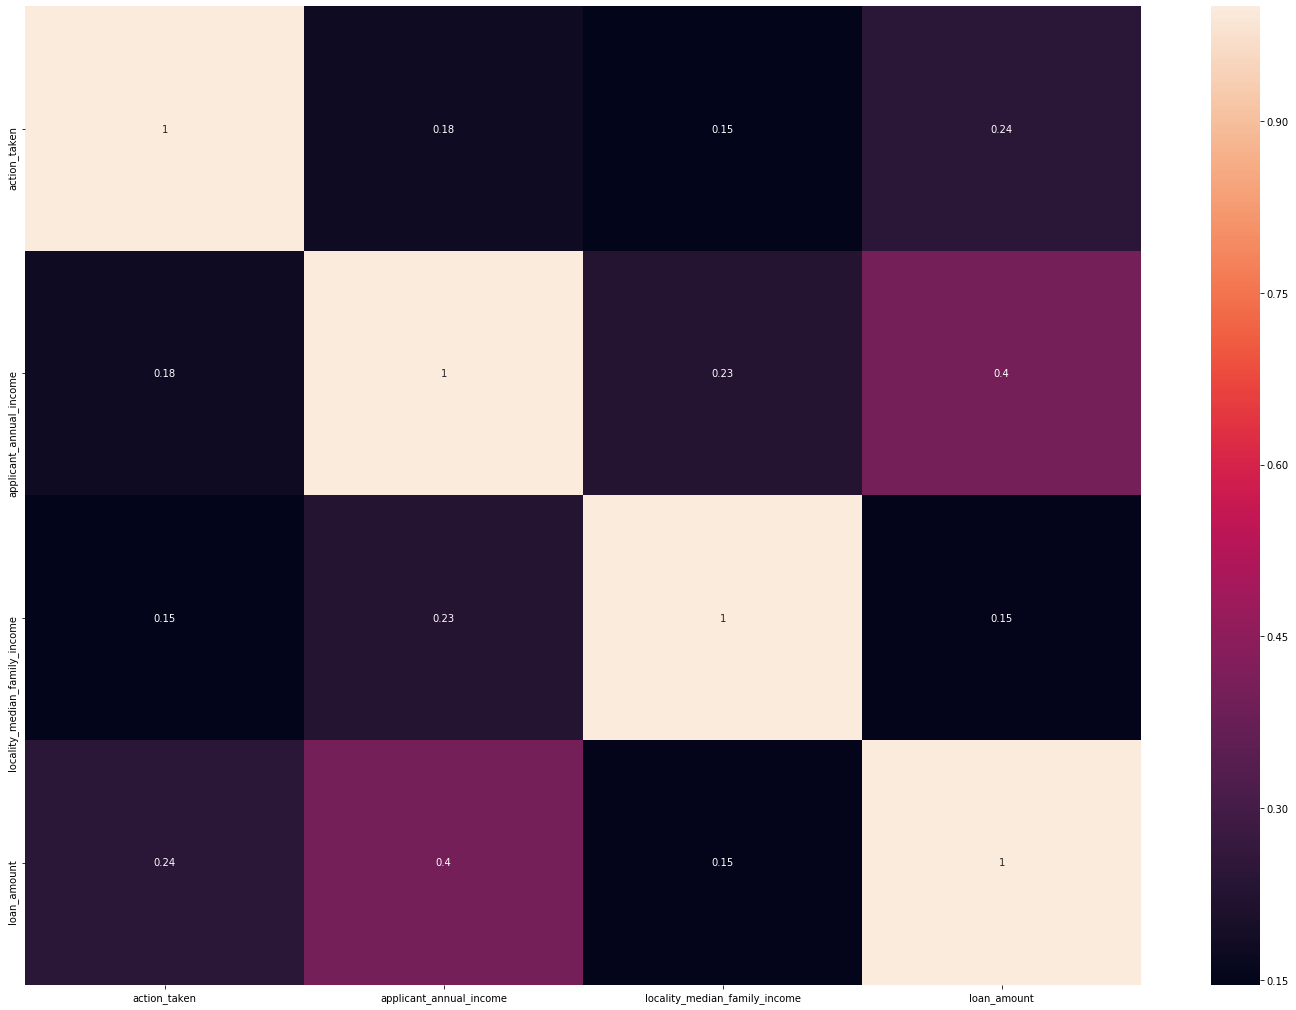

In [20]:
sns.heatmap(df.corr(),annot = True)

In [18]:
df['loan_amount'].nunique()

530

- although loan_amount column seems to have a high number of unique values it displays a somewhat good correlation with the target variable at 0.24
- all the other columns as well have a pretty moderate correlation with the target variable
- hence it's been decided to not drop any numerical columns on the data.

In [6]:
df.describe(include = 'object')

,agency_name,applicant_race,applicant_sex,lien_status_name,loan_purpose_name
count,2005,2005,2005,2005,2005
unique,6,7,4,3,3
top,CFPB,White,Male,Secured by a first lien,Home purchase
freq,690,1412,1199,1731,989


In [21]:
df['applicant_sex'].unique()

array(['Male', 'Female', 'Information not provided', 'Not applicable'],
      dtype=object)

In [43]:
df['applicant_race'].unique()

array(['White', 'American Indian or Alaska Native', 'Asian',
       'Information not provided', 'Black or African American',
       'Not applicable', 'Native Hawaiian or Other Pacific Islander'],
      dtype=object)

In [45]:
df['applicant_race'].value_counts()

White                                        1283
Information not provided                      192
Black or African American                     151
Asian                                         134
Not applicable                                 21
American Indian or Alaska Native               12
Native Hawaiian or Other Pacific Islander       6
Name: applicant_race, dtype: int64

- The categorical columns here do havea significant unique values that seem to provide information which would be helpful from a business perspective.
- Since applicant_sex,applicant_race variables seems to have entries with ambiguous information, it's been decided to drop the columns.


In [22]:
df.drop('applicant_sex',axis = 1, inplace = True)

In [47]:
df.drop('applicant_race',axis = 1, inplace = True)

In [48]:
# encoding the categorical columns

df_encoded = pd.get_dummies(df,drop_first = True)
df_encoded.head()

,action_taken,applicant_annual_income,locality_median_family_income,loan_amount,agency_name_FDIC,agency_name_FRS,agency_name_HUD,agency_name_NCUA,agency_name_OCC,lien_status_name_Secured by a first lien,lien_status_name_Secured by a subordinate lien,loan_purpose_name_Home purchase,loan_purpose_name_Refinancing
0,1,121000.0,109000,232000,0,0,1,0,0,1,0,1,0
1,1,31000.0,82700,9000,0,0,0,1,0,1,0,0,0
2,1,82000.0,69000,210000,0,0,0,0,0,1,0,1,0
3,1,98000.0,82700,178000,0,0,1,0,0,1,0,0,1
4,1,83000.0,109000,200000,0,0,0,1,0,1,0,0,1


In [49]:
df_encoded.shape

(1799, 13)

In [50]:
df_num = df.select_dtypes(include = np.number)

In [51]:
# assigning the X and Y variables

X = df_encoded.drop('action_taken',axis = 1)
Y = df_encoded['action_taken']

In [52]:
# since the data has imbalanced classes smote will be performed to give the calsss a equal weigthage

smote = SMOTE(sampling_strategy='auto',random_state=1)
X_new, Y_new = smote.fit_resample(X,Y)

df_smote = pd.concat([X_new,Y_new])

print(Y_new.value_counts().sort_index())

0    1489
1    1489
Name: action_taken, dtype: int64


the above values are the new values for the X and Y variables in a more balanced way.

In [53]:
#Performing scaling
sc = StandardScaler()

X_scaled = pd.DataFrame(sc.fit_transform(X_new),columns = X_new.columns)

In [54]:
# adding constant as we aim to build a logistic regression model

X_scaled = sma.add_constant(X_scaled)

In [63]:
# performing train test split

x_train,x_test,y_train,y_test = train_test_split(X_scaled,Y_new,test_size = 0.30,random_state = 1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2084, 13)
(894, 13)
(2084,)
(894,)


performing statistical test of independence to determine the validity of the train and test data.

- h0 : variables are significant
- h1 : variables are insignificant

alpha is 0.05

In [56]:
stats.ttest_ind(X_scaled,Y_new)

Ttest_indResult(statistic=array([ 54.56189146, -24.40081966, -24.40081966, -24.40081966,
       -24.40081966, -24.40081966, -24.40081966, -24.40081966,
       -24.40081966, -24.40081966, -24.40081966, -24.40081966,
       -24.40081966]), pvalue=array([0.00000000e+000, 2.03452907e-125, 2.03452907e-125, 2.03452907e-125,
       2.03452907e-125, 2.03452907e-125, 2.03452907e-125, 2.03452907e-125,
       2.03452907e-125, 2.03452907e-125, 2.03452907e-125, 2.03452907e-125,
       2.03452907e-125]))

here pval displays a moderate relation of variables.

### 3. Model Building 

### Base Model :

- A logistic Regression model will be built as our base model.
- The model built from scipy library will help us find the significance of variables.
- Themodel built using the scikit library will help us display the accuracy of the model built.

In [57]:
lr_base = sma.Logit(y_train,x_train).fit()
lr_base.summary()

         Current function value: 0.350822
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           action_taken   No. Observations:                 2084
Model:                          Logit   Df Residuals:                     2071
Method:                           MLE   Df Model:                           12
Date:                Fri, 10 Mar 2023   Pseudo R-squ.:                  0.4939
Time:                        05:59:27   Log-Likelihood:                -731.11
converged:                      False   LL-Null:                       -1444.5
Covariance Type:            nonrobust   LLR p-value:                2.357e-298
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                              0.9305   1014.125      0.001      0.999   -1986.717    1988.578
applicant_annual_income                            0.4040      0.081      5.012      0.000       0.246       0.562
locality_median_family_income                      0.2939      0.069      4.265      0.000       0.159       0.429
loan_amount                                        0.2676      0.090      2.959      0.003       0.090       0.445
agency_name_FDIC                                   5.4564   4746.677      0.001      0.999   -9297.859    9308.771
agency_name_FRS                                    0.3437      0.070      4.912      0.000       0.207       0.481
agency_name_HUD                                    0.2651      0.065      4.060      0.000       0.137       0.393
agency_name_NCUA                                   0.9414      0.084     11.180      0.000       0.776       1.106
agency_name_OCC                                    0.3797      0.087      4.348      0.000       0.209       0.551
lien_status_name_Secured by a first lien           0.5069      0.166      3.054      0.002       0.182       0.832
lien_status_name_Secured by a subordinate lien     0.8934      0.132      6.788      0.000       0.635       1.151
loan_purpose_name_Home purchase                    1.6208      0.113     14.355      0.000       1.400       1.842
loan_purpose_name_Refinancing                      0.6135      0.107      5.732      0.000       0.404       0.823
==================================================================================================================
"""

- The model was selected after 35 iterations
- applicant_annual_income,locality_median_family_income, lien_status_name_Secured by a subordinate lien, lien_status_name_Secured by a first lien,agency fdic and ncua show a probability of having higher outcome with relation to target variable.
- all the other column show a decent probability of having a outcome with relation to the target_variable

In [58]:
lr = LogisticRegression(random_state=1)
lr_model = lr.fit(x_train,y_train)

trainpred_lr = lr_model.predict(x_train)
testpred_lr = lr_model.predict(x_test)
prob = lr_model.predict_proba(x_test)
pred_prob_lr = prob[:,1]

In [59]:
print(classification_report(y_train,trainpred_lr))
print(classification_report(y_test,testpred_lr))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1047
           1       0.83      0.86      0.85      1037

    accuracy                           0.84      2084
   macro avg       0.84      0.84      0.84      2084
weighted avg       0.84      0.84      0.84      2084

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       442
           1       0.82      0.84      0.83       452

    accuracy                           0.82       894
   macro avg       0.82      0.82      0.82       894
weighted avg       0.82      0.82      0.82       894



- here the training data is higher than test data accuracy score by a moderate number.
- The pecision between classes 0 with respect to 1 display a lower difference. This can show that the probability of the loan being rejected is comparatively lesser.  
- In this case it can be said the model is a overfit.

In [62]:
# before moving onto the next model building, the data will be resplitted as certain columns do not requiure scaling done to them
xtrain,xtest,ytrain,ytest = train_test_split(X_new,Y_new,test_size = 0.30,random_state = 1)

### ADA boost model :

A boosting model will help us set a number of estimators that might help us get an accuracy that we desire, after the model get's iterated for multpile times.

The number of iterations will give us the model with the best , most feasible results.


In [64]:
ada_model = AdaBoostClassifier(n_estimators=10,random_state=1)

ada_model.fit(xtrain,ytrain)

trainpred_ada = ada_model.predict(xtrain)
testpred_ada = ada_model.predict(xtest)
prob = ada_model.predict_proba(xtest)
pred_prob_ada = prob[:,1]

In [65]:
print(classification_report(ytrain,trainpred_ada))
print(classification_report(ytest,testpred_ada))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1047
           1       0.91      0.76      0.83      1037

    accuracy                           0.84      2084
   macro avg       0.85      0.84      0.84      2084
weighted avg       0.85      0.84      0.84      2084

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       442
           1       0.89      0.75      0.81       452

    accuracy                           0.83       894
   macro avg       0.84      0.83      0.83       894
weighted avg       0.84      0.83      0.83       894



- here the accuracy score of training data and testing data does not have a much of a difference.
- Hence in this case, it can be said that the model is overfit

### Decision Tree Model :

Since the above models have been giving almost overfit model conditions, it seems there is a need for hyper parameter tuning to build a good model.

Decision tree helps us with finding the best parameters that can be utilised to build a model with the help of gridsearch cv

In [67]:
dt = DecisionTreeClassifier()

dt_params = [{'criterion':['entropy','gini'],
             'max_features':['sqrt','log2'],
             'max_depth':range(2,5),
             'min_samples_split':range(2,5)}]

dt_grid = GridSearchCV(estimator = dt, param_grid = dt_params,cv = 3)

dt_grid.fit(xtrain,ytrain)

dt_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_split': 4}

In [68]:
dt_model = DecisionTreeClassifier(criterion = dt_grid.best_params_.get('criterion'),
                                 max_features = dt_grid.best_params_.get('max_features'),
                                 max_depth = dt_grid.best_params_.get('max_depth'),
                                 min_samples_split=dt_grid.best_params_.get('min_samples_split'),
                                 random_state = 1)
dt_model.fit(xtrain,ytrain)

trainpred_dt = dt_model.predict(xtrain)
testpred_dt = dt_model.predict(xtest)
prob = dt_model.predict_proba(xtest)
pred_prob_dt = prob[:,1]

In [69]:
print(classification_report(ytrain,trainpred_dt))
print(classification_report(ytest,testpred_dt))

              precision    recall  f1-score   support

           0       0.92      0.53      0.67      1047
           1       0.67      0.95      0.78      1037

    accuracy                           0.74      2084
   macro avg       0.79      0.74      0.73      2084
weighted avg       0.79      0.74      0.73      2084

              precision    recall  f1-score   support

           0       0.89      0.53      0.67       442
           1       0.67      0.94      0.78       452

    accuracy                           0.74       894
   macro avg       0.78      0.73      0.72       894
weighted avg       0.78      0.74      0.73       894



- Here the model is overfit as the accuracy score of training data and test data is same.

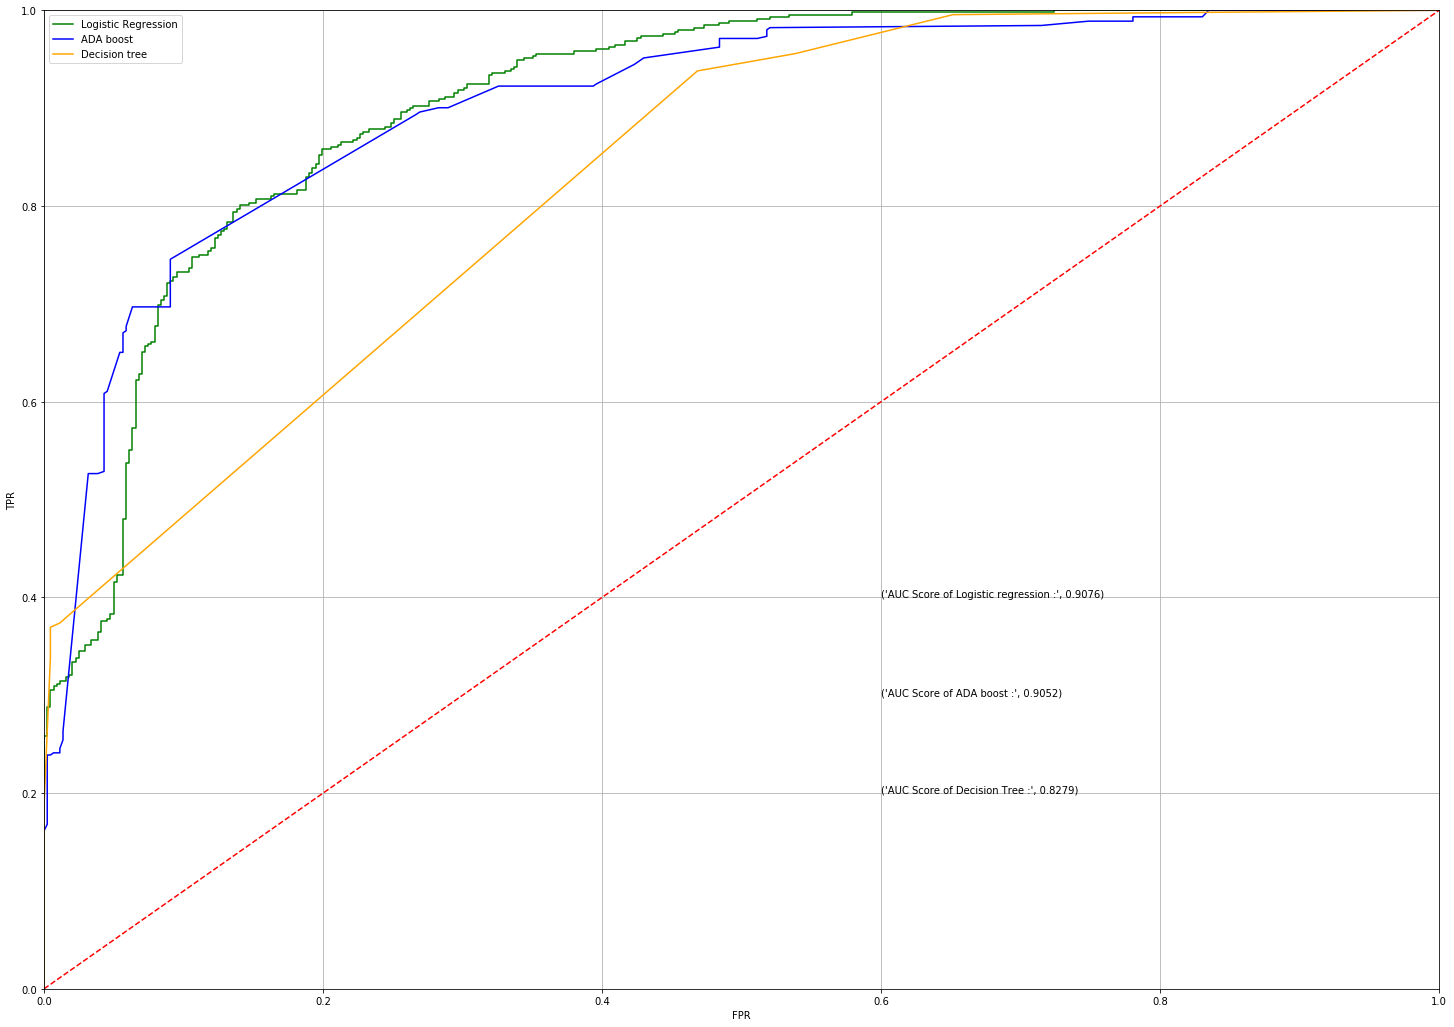

In [73]:
# plotting roc_auc_score plot

fpr,tpr,thresholds = roc_curve(ytest,pred_prob_lr)
plt.plot(fpr,tpr,color = 'green',label = 'Logistic Regression')

fpr,tpr,thresholds = roc_curve(ytest,pred_prob_ada)
plt.plot(fpr,tpr,color = 'blue',label = 'ADA boost')

fpr,tpr,thresholds = roc_curve(ytest,pred_prob_dt)
plt.plot(fpr,tpr,color = 'orange',label = 'Decision tree')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.plot([0,1],[0,1],'r--')

auc_lr = round(roc_auc_score(ytest,pred_prob_lr),4)
plt.text(x = 0.6,y = 0.4,s = ('AUC Score of Logistic regression :',auc_lr))

auc_ada = round(roc_auc_score(ytest,pred_prob_ada),4)
plt.text(x = 0.6,y = 0.3,s = ('AUC Score of ADA boost :',auc_ada))

auc_dt = round(roc_auc_score(ytest,pred_prob_dt),4)
plt.text(x = 0.6,y = 0.2,s = ('AUC Score of Decision Tree :',auc_dt))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

### Business interpretation :

- Here looking at the roc curve of the models built, ADA boost and logistic regression are covering somewhat similar area under the curve.

- We will select logistic regression model as our best model as it showcases a good performance and has better accuracy score and auc score as well.

- applicant_annual_income,locality_median_family_income, lien_status_name_Secured by a subordinate lien, lien_status_name_Secured by a first lien,agency fdic and ncua show a probability of having higher outcome with relation to target variable. These columns can be considered, and targeted in orfer too reach maximum business solutions.The above variables show that the first and subordinate lien status have a higher probability rate to detrermine the loan action taken alongwith loan purpose given. an approval of that status can be considered as a prominent indicator for making a decision for the applicant's loan application.

- As observed The logistic regression model performs well as per the parametrics as well as aligns with the variables that play key roles. Hence logistic regression model is being considered as a first choice for being a goodfit model for our business problem.
